In [1]:
import os
import sys
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from data_handle import(
    ForexDataClean,
    ForexDataLoad
)

from features import ForexFeauturesExtractor

from plots import ForexPlotter
from models import TimeSeriesAutoencoder
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

data = ForexDataLoad(file_path = '../data/usdjpy.csv').data

cleaner = ForexDataClean(data = data)
data = cleaner.fast_cleaner()

features = ForexFeauturesExtractor(
    data = data,
    momentum_parameters = {
        'rsi_periods' : [4, 6, 8, 10, 12, 14]*10,
        'stoch_fk_sk_sd_periods' : [[4, 1, 1], [6, 1, 1], [8, 2, 2], [10, 2, 2], [12, 3, 3], [14, 3, 3]]*10,
        'williams_periods' :  [4, 6, 8, 10, 12, 14]*10,
        'cci_periods' :  [4, 6, 8, 10, 12, 14]*10,
        'momentum_periods' : [4, 6, 8, 10, 12, 14]*10
    },
)

indicators_data, signals_data, extreme_data = features.extract_all_features()


FOREX DATA LOADER
 Available Fuctions 
1 load_csv 
2 load_from_database
Data loaded successfully!
Shape: (41476, 5)

FOREX DATA CLEANER
 Available Fuctions 
1 remove_duplicates 
2 handle_missing_values 
3 validate_ohlc_integrity 
4 handle_outliers 
5 fast_cleaner
Keep = first and subset = None
Removed 0 duplicate entries
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent
No missing values found
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent


In [2]:
trend_dir = signals_data['trend_strength']

In [3]:
trend_dir.shape

(41276, 23)

In [4]:
autoencoder = TimeSeriesAutoencoder(
    input_dim = trend_dir.shape[1] - 1,  
    encoding_dim = 2,
    learning_rate = 0.001
)

In [5]:
train_data, test_data = autoencoder.prepare_data(
    trend_dir, 
    target_column = 'close',
    test_size = 0.3
)

Training samples: 28893
Test samples: 12383


In [6]:
history = autoencoder.train(
    epochs = 100, 
    batch_size = 12, 
    verbose = 1
)

Epoch 1/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.4651 - mae: 0.4091 - val_loss: 0.6664 - val_mae: 0.4453
Epoch 2/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3398 - mae: 0.3261 - val_loss: 0.5666 - val_mae: 0.3591
Epoch 3/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2921 - mae: 0.2936 - val_loss: 0.6856 - val_mae: 0.3646
Epoch 4/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2786 - mae: 0.2827 - val_loss: 0.5597 - val_mae: 0.3610
Epoch 5/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2651 - mae: 0.2735 - val_loss: 0.5310 - val_mae: 0.3439
Epoch 6/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2573 - mae: 0.2690 - val_loss: 0.4536 - val_mae: 0.3136
Epoch 7/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2445 - mae: 0.2616 - val_loss: 0.4782 - val_mae: 0.3119
Epoch 8/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2430 - mae: 0.2572 - val_loss: 0.4424 - val_mae: 0.3013
Epoch 9/100
2408/2408 ━━━━━━━━━━

In [7]:
labels_data_with_latent = autoencoder.add_latent_features(trend_dir)

In [8]:
metrics = autoencoder.evaluate()
print("\nModel Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Model Metrics:
final_training_loss: 0.1950
final_validation_loss: 0.3346
training_reconstruction_error: 0.1582
test_reconstruction_error: 0.3346
generalization_gap: 0.1764


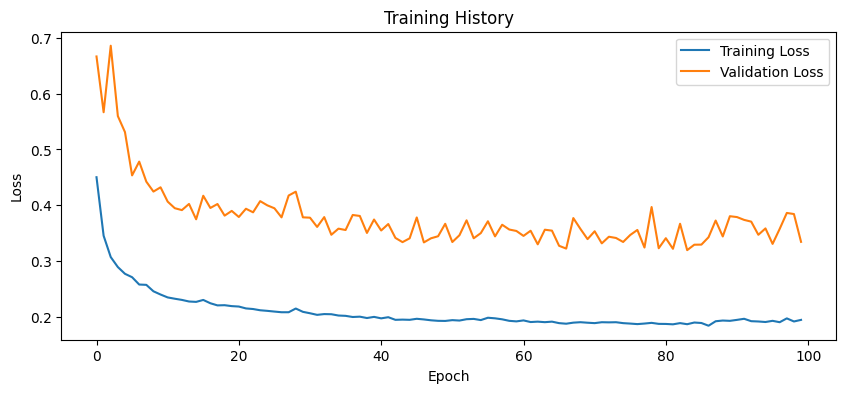

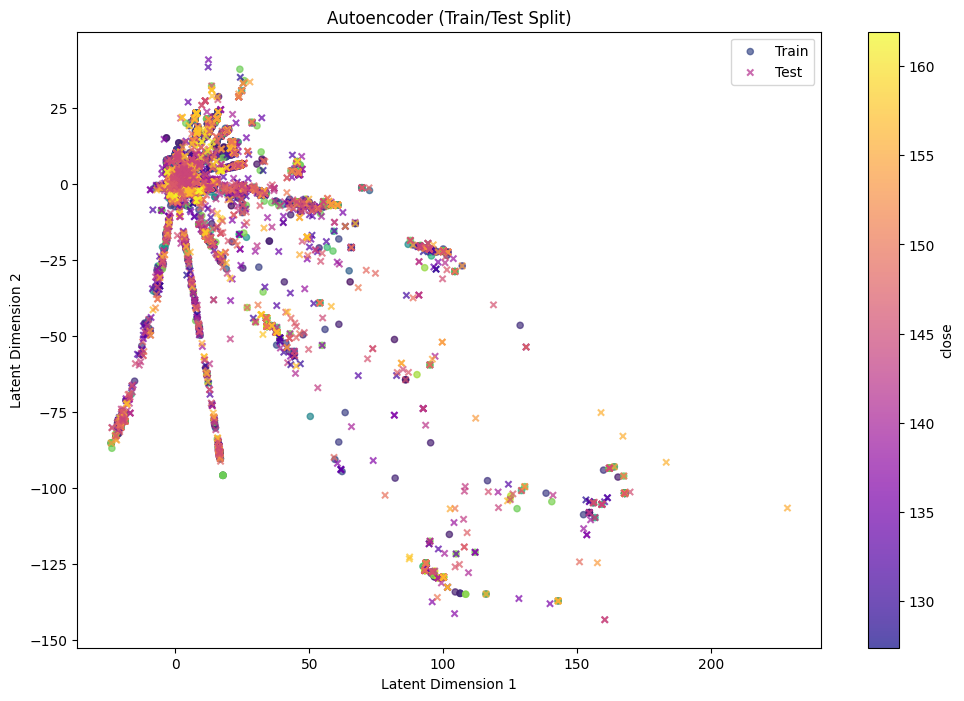

In [9]:
autoencoder.plot_training_history()
autoencoder.plot_latent_space(
    labels_data_with_latent, 
    color_by = 'close'
)

In [10]:
df = labels_data_with_latent[[
    'close', 
    'latent_dim_1', 
    'latent_dim_2'
]]

In [11]:
print(df.tail())

                       close  latent_dim_1  latent_dim_2
datetime                                                
2024-09-02 14:00:00  146.985     -1.238858     -0.020055
2024-09-02 15:00:00  146.979     14.280397    -38.203320
2024-09-02 16:00:00  146.961     -1.969229     -1.731424
2024-09-02 17:00:00  146.959     -1.969229     -1.731424
2024-09-02 18:00:00  146.923     -1.962153     -1.723554


In [12]:
close_prices = labels_data_with_latent['close'].values

min_indices = argrelextrema(
    close_prices, 
    np.less, 
    order = 5
)[0]

max_indices = argrelextrema(
    close_prices, 
    np.greater, 
    order = 5
)[0]

labels_data_with_latent['is_extrema'] = 0
labels_data_with_latent.loc[labels_data_with_latent.index[min_indices], 'is_extrema'] = 1 
labels_data_with_latent.loc[labels_data_with_latent.index[max_indices], 'is_extrema'] = 2  

normal_points = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 0]
minima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 1]
maxima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 2]

for extrema_type, data, label in [
    (0, normal_points, 'Normal Points'),
    (1, minima_latent, 'Minima (Buy)'),
    (2, maxima_latent, 'Maxima (Sell)')
]:
    
    print(f"\n {label} (n={len(data)}):")
    print(f"Latent Dim 1: {data['latent_dim_1'].mean():.4f} ± {data['latent_dim_1'].std():.4f}")
    print(f"Latent Dim 2: {data['latent_dim_2'].mean():.4f} ± {data['latent_dim_2'].std():.4f}")


 Normal Points (n=36130):
Latent Dim 1: 5.7566 ± 15.0597
Latent Dim 2: -1.2719 ± 14.7834

 Minima (Buy) (n=2540):
Latent Dim 1: 8.6999 ± 19.7805
Latent Dim 2: -3.0724 ± 15.5985

 Maxima (Sell) (n=2606):
Latent Dim 1: 3.9757 ± 13.5310
Latent Dim 2: -1.2155 ± 17.5827


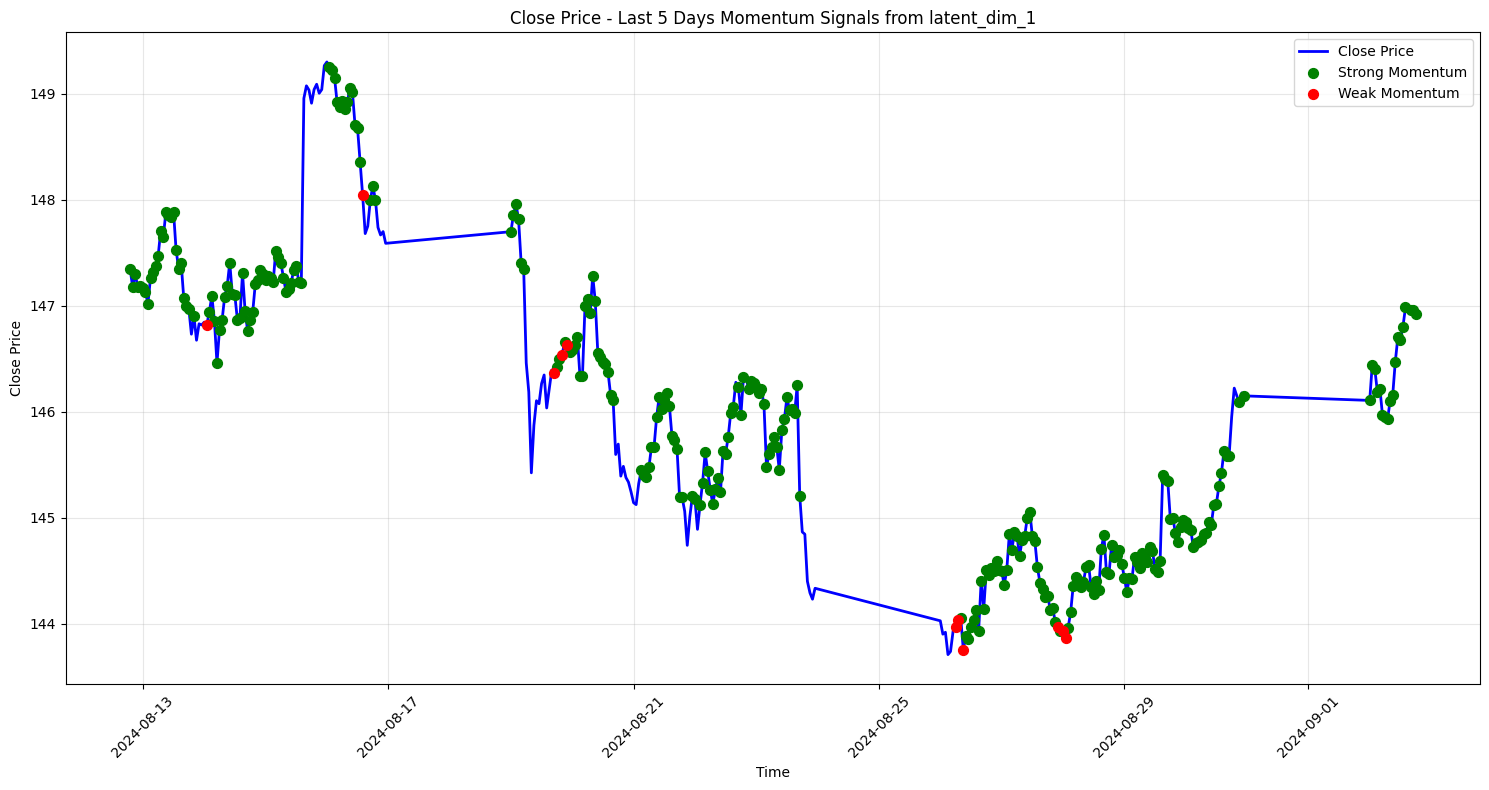

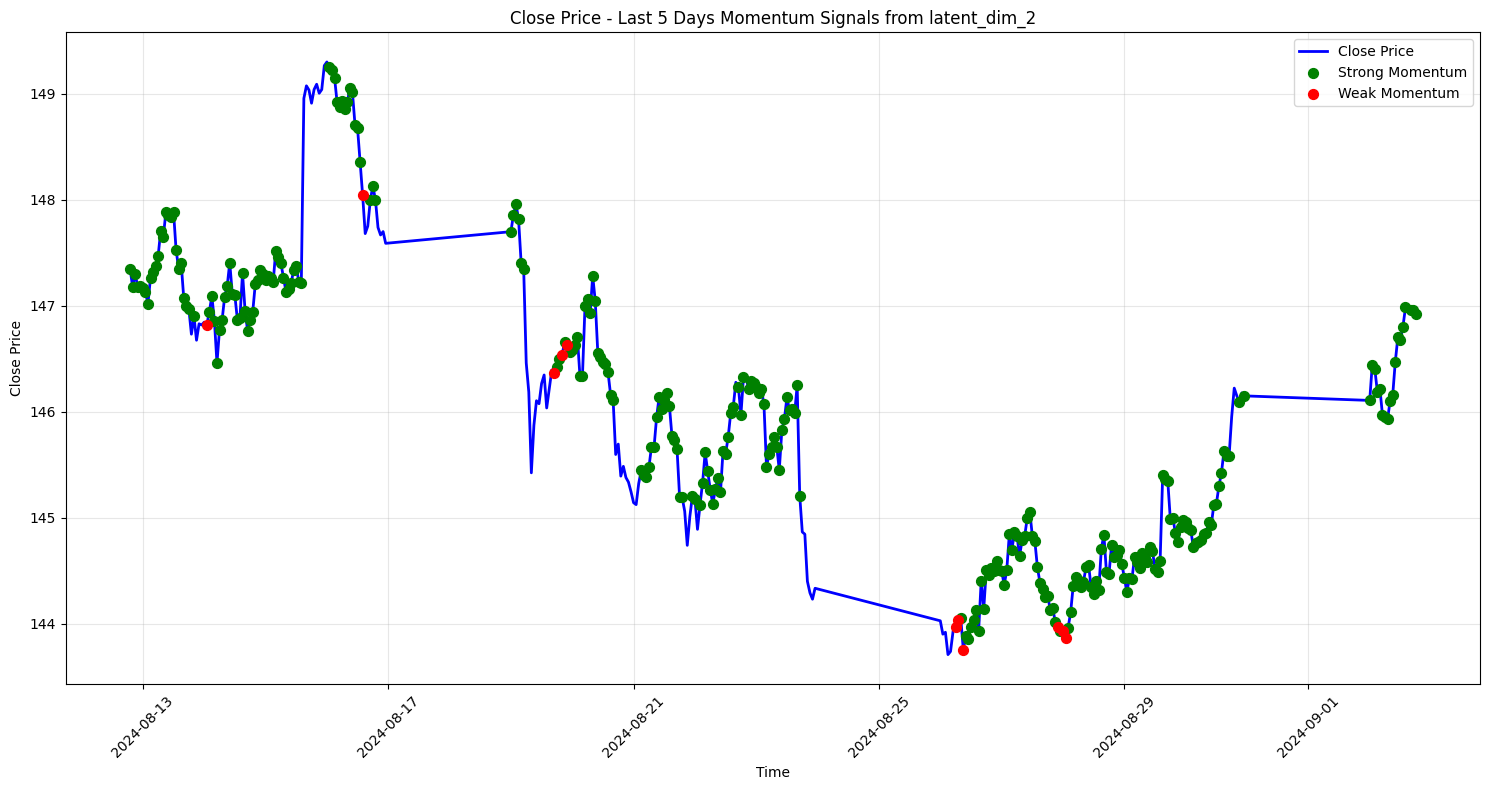

Strong Momentum:284
Weak Momentum:11


In [13]:
def auto_signal(
    latent_1, 
    latent_2
):
    buy_zone_l1 = (
        minima_latent['latent_dim_1'].mean() - 1.5 * minima_latent['latent_dim_1'].std(),
        minima_latent['latent_dim_1'].mean() + 1.5 * minima_latent['latent_dim_1'].std()
    )

    buy_zone_l2 = (
        minima_latent['latent_dim_2'].mean() - 1.5 * minima_latent['latent_dim_2'].std(),
        minima_latent['latent_dim_2'].mean() + 1.5 * minima_latent['latent_dim_2'].std()
    )

    sell_zone_l1 = (
        maxima_latent['latent_dim_1'].mean() - 1.5 * maxima_latent['latent_dim_1'].std(),
        maxima_latent['latent_dim_1'].mean() + 1.5 * maxima_latent['latent_dim_1'].std()
    )

    sell_zone_l2 = (
        maxima_latent['latent_dim_2'].mean() - 1.5 * maxima_latent['latent_dim_2'].std(),
        maxima_latent['latent_dim_2'].mean() + 1.5 * maxima_latent['latent_dim_2'].std()
    )
    
    if (sell_zone_l1[0] <= latent_1 <= sell_zone_l1[1] and sell_zone_l2[0] <= latent_2 <= sell_zone_l2[1]):
        return 'sell'
    elif (buy_zone_l1[0] <= latent_1 <= buy_zone_l1[1] and buy_zone_l2[0] <= latent_2 <= buy_zone_l2[1]):
        return 'buy'
    else:
        return 'hold'

last_5_days = labels_data_with_latent.tail(24 * 15)
last_5_days['signal'] = last_5_days.apply(
    lambda row: auto_signal(row['latent_dim_1'], row['latent_dim_2']), axis=1
)

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index, 
    last_5_days['close'], 
    linewidth=2, 
    label='Close Price',
    color='blue'
)

buy_signals_1 = last_5_days[last_5_days['signal'] == 'sell']
sell_signals_1 = last_5_days[last_5_days['signal'] == 'buy']

plt.scatter(
    buy_signals_1.index, 
    buy_signals_1['close'], 
    color='green', 
    marker='o', 
    s=50, 
    label='Strong Momentum',
    zorder=5
)

plt.scatter(
    sell_signals_1.index,
    sell_signals_1['close'], 
    color='red',
    marker='o', 
    s=50,
    label='Weak Momentum',
    zorder=5
)

plt.title('Close Price - Last 5 Days Momentum Signals from latent_dim_1')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index,
    last_5_days['close'],
    linewidth=2,
    label='Close Price',
    color='blue'
)

buy_signals_2 = last_5_days[last_5_days['signal'] == 'sell']
sell_signals_2 = last_5_days[last_5_days['signal'] == 'buy']

plt.scatter(
    buy_signals_2.index,        
    buy_signals_2['close'], 
    color='green',
    marker='o', 
    s=50, 
    label='Strong Momentum', 
    zorder=5
)

plt.scatter(
    sell_signals_2.index, 
    sell_signals_2['close'], 
    color='red',
    marker='o',
    s=50,
    label='Weak Momentum',
    zorder=5
)

plt.title('Close Price - Last 5 Days Momentum Signals from latent_dim_2')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print(f"Strong Momentum:{len(buy_signals_1)}")
print(f"Weak Momentum:{len(sell_signals_1)}")